In [1]:
import pandas as pd
import numpy as np

import nltk
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
%matplotlib inline

from collections import Counter

In [2]:
data = pd.read_csv('./attacks.csv', encoding = 'ISO-8859-1')

## Quick Review

In [3]:
data.head(2)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2017.11.30.b,30-Nov-2017,2017.0,Unprovoked,COSTA RICA,Cocos Island,Manuelita,Scuba Diving,__ Jimenez,M,...,"Tiger shark, female",R. Arauz,2017.11.30.b-Jimenez.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2017.11.30.b,2017.11.30.b,6221.0,NaN,NaN
1,2017.11.30.a,30-Nov-2017,2017.0,Unprovoked,COSTA RICA,Cocos Island,Manuelita,Scuba diving,Rohina Bhandari,F,...,"Tiger shark, female",R. Arauz,2017.11.30.a-Bhandari.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2017.11.30.a,2017.11.30.a,6220.0,NaN,NaN


## Working with Dataset

In [4]:
names = list(data.columns)
names[9] = 'Sex'
names[12] = 'Fatal'
names[14] = 'Species'
data.columns = names

In [5]:
def year_prettify(year):
    if year > 1000: 
        return year
    else:
        return np.nan
    
def sex_prettify(sex):
    if sex == 'M' or sex == 'F':
        return sex
    else:
        return np.nan
    
def age_prettify(age):
    try:
        age = int(age)
    except ValueError:
        age = 0
        
    if (age > 0 and age <= 100):
        return age
    else:
        return np.nan
    
def fatal_prettify(fatal):
    if fatal == 'N' or fatal == 'Y':
        return fatal
    else:
        return np.nan
    
def date_prettify(date):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    num_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    date = str(date)
    if (len(date) == 11 and date[2] == '-'):
        for i in range(len(months)):
            date = date.replace(months[i], num_months[i])
        return date
    else:
        return np.nan

In [6]:
data['Year'] = data['Year'].apply(year_prettify)
data['Sex'] = data['Sex'].apply(sex_prettify)
data['Age'].fillna(0, inplace=True)
data['Age'] = data['Age'].apply(age_prettify)
data['Fatal'] = data['Fatal'].apply(fatal_prettify)

In [7]:
data['Date'] = data['Date'].apply(date_prettify)

## Fatal Chart

In [8]:
fatal_vals = data['Fatal'].value_counts().tolist()

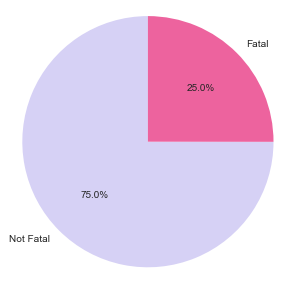

In [9]:
f, ax = plt.subplots(figsize=(5, 5))

labels = ['Not Fatal', 'Fatal']
colors = ['#d6d1f5', '#ed639e']

plt.pie(fatal_vals, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
 
axis = plt.axis('equal')

## Sex Chart

In [10]:
sex_vals = data['Sex'].value_counts().tolist()

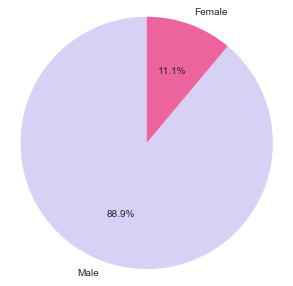

In [11]:
f, ax = plt.subplots(figsize=(5, 5))

labels = ['Male', 'Female']
colors = ['#d6d1f5', '#ed639e']

plt.pie(sex_vals, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)

axis = plt.axis('equal')

## Age Chart

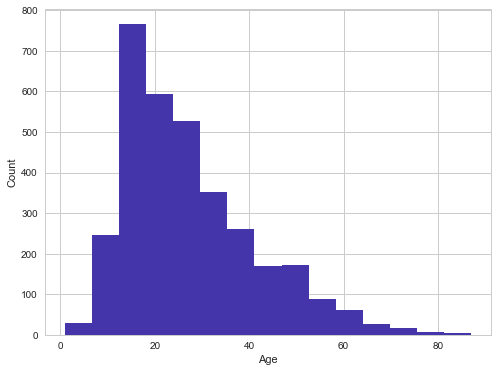

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(data['Age'].dropna(),  
             hist_kws={"alpha": 1, "color": "#4535aa"}, 
             kde=False, bins=15)

ax = ax.set(ylabel="Count", xlabel="Age")

## Top Activities

In [13]:
most_common_activities = Counter(data['Activity'].dropna().tolist()).most_common(20)
activities = [actv_list[0] for actv_list in most_common_activities]
counts = [actv_list[1] for actv_list in most_common_activities]

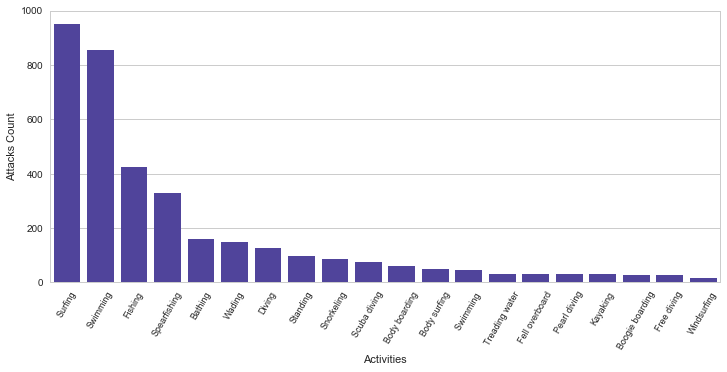

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x=activities, y=counts, color='#4535aa', ax=ax)
ax.set(ylabel="Attacks Count", xlabel="Activities")

ticks = plt.setp(ax.get_xticklabels(), rotation=60, fontsize=9)

## Species

In [15]:
most_common_species = Counter(data['Species'].dropna().tolist()).most_common(20)

species = [species_list[0] for species_list in most_common_species]
for i in species:
    print(i)

White shark
Shark involvement prior to death was not confirmed
Invalid
Shark involvement not confirmed
Tiger shark
Shark involvement prior to death unconfirmed
Bull shark
4' shark
6' shark
1.8 m [6'] shark
Questionable incident
Questionable
1.5 m [5'] shark
5' shark
1.2 m [4'] shark
3' shark
4' to 5' shark
2 m shark
3 m [10'] shark
No shark involvement


## Working with Dates

In [16]:
dates = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

In [17]:
days = dates.dropna().map(lambda x: x.day)

days_counter = Counter(days)
days_keys = list(days_counter.keys())
days_values = list(days_counter.values())

In [18]:
months = dates.dropna().map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

months_labels = months.apply(get_season)

months_counter = Counter(months_labels)
months_keys = list(months_counter.keys())
months_values = list(months_counter.values())

### Days

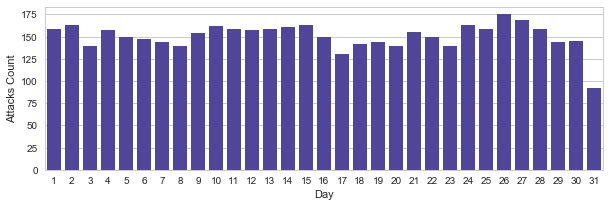

In [19]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x=days_keys, y=days_values, color='#4535aa', ax=ax)
ax = ax.set(ylabel="Attacks Count", xlabel="Day")

### Months

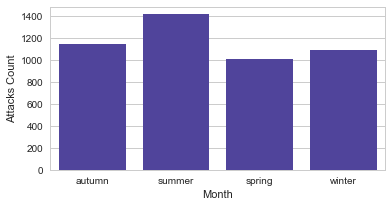

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(x=months_keys, y=months_values, color='#4535aa', ax=ax)
ax = ax.set(ylabel="Attacks Count", xlabel="Month")

## Exploring Injury Causes

In [21]:
activity_texts = data['Injury'].tolist()

In [22]:
activity_texts[:10]

['Serious injury to leg',
 'FATAL',
 'FATAL',
 'Right leg bitten',
 'Heel bitten',
 'Puncture wounds to feet',
 'Puncture wounds to left shoulder',
 'FATAL',
 'Calf injured',
 'Minor injury to foot']

In [23]:
wordnet_lemmatizer = WordNetLemmatizer()

In [24]:
def keep_only_letters(text):
    cleaned_text = ''
    for char in text:
        if (char.isalpha() or char == ' '):
            cleaned_text += char
    return cleaned_text

In [25]:
lemm_activity_texts = []
for text in activity_texts:
    text = keep_only_letters(str(text)).lower()   
    lemm_text = []
    for word in text.split():
        lemm_text.append(wordnet_lemmatizer.lemmatize(word))
    lemm_activity_texts.append(lemm_text)

In [26]:
dictionary = corpora.Dictionary(lemm_activity_texts)

In [27]:
word_list = []
for key, value in dictionary.dfs.items():
    if value > 50:
        word_list.append(key)

In [28]:
dictionary.filter_tokens(word_list)
corpus = [dictionary.doc2bow(text) for text in lemm_activity_texts]

In [29]:
np.random.seed(76543)
lda = models.LdaModel(corpus, num_topics=20, id2word=dictionary, passes=5)

/anaconda3/lib/python3.6/site-packages/gensim-3.4.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:579: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [30]:
topics = lda.show_topics(num_topics=20, num_words=5, formatted=False)

In [31]:
topics = lda.show_topics(num_topics=20, num_words=5, formatted=False)
for topic in topics:
    num = int(topic[0]) + 1
    print('Cause %d:' % num, end=' ')
    print(', '.join([pair[0] for pair in topic[1]]))

Cause 1: side, face, dinghy, propeller, raft
Cause 2: struck, then, knocked, mark, shot
Cause 3: thought, thumb, rudder, be, tooth
Cause 4: fish, seized, lifted, piece, tail
Cause 5: presumed, ashore, some, an, x
Cause 6: elbow, attack, that, died, crew
Cause 7: killed, below, may, men, due
Cause 8: head, damaged, small, neck, said
Cause 9: shin, ski, holed, large, diving
Cause 10: hit, bruised, torn, femur, harpooned
Cause 11: found, speared, disappeared, upper, had
Cause 12: perished, nipped, unconfirmed, time, prior
Cause 13: human, swim, tiger, gut, defense
Cause 14: caught, abraded, man, or, out
Cause 15: netted, survivor, people, lost, inch
Cause 16: probable, scavenging, captive, made, onboard
Cause 17: day, kayak, two, rescued, other
Cause 18: above, oar, drowned, broken, artery
Cause 19: into, removed, leapt, one, her
Cause 20: grabbed, tail, multiple, took, dorsum
